# Data mining (No-show)
## Phases 4 & 5 CRISP - DM : Modélisation
## Outline
- [Préliminaire](#1)
- [4 - Modeling and Evaluation ](#4)
  - [4.1 - Random Forest](#4.1)
      - [4.1.1 - Training model](#4.1.1)
      - [4.1.2 - Evaluation ](#4.1.2)
  - [4.2 - XGBoost](#4.2)    
      - [4.2.1 - Training model](#4.2.1)
      - [4.2.2 - Evaluation ](#4.2.2)
  - [4.3 - AdaBoost ](#4.3)    
      - [4.3.1 - Training model](#4.3.1)
      - [4.3.2 - Evaluation ](#4.3.2)
  - [4.4 - ANN (MLP)](#4.4)    
      - [4.4.1 - Training model](#4.4.1)
      - [4.4.2 - Evaluation ](#4.4.2)

<a name="1"></a>
## Préliminaires

In [1]:
#Load our local fonctions
from utils_ns import *
# load librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv("data_st/data_prep.csv")

In [15]:
data.drop(['patientsid'], axis = True, inplace=True)

<a name="3.2.3"></a>
3.2.3 - Data Standardization/normalisation

In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['state'] = label_encoder.fit_transform(data['state'])

In [16]:
# Division des données en ensembles d'entraînement et de test
X = data.drop('NoShow', axis=1)
y = data['NoShow']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y, shuffle=True)

In [4]:
print(f"nombre de show(0) et no-show(1) dans y_train\n", y_train.value_counts())

nombre de show(0) et no-show(1) dans y_train
 NoShow
0         7693170
1          246659
Name: count, dtype: int64


In [5]:
print(f"nombre de show(0) et no-show(1) dans y_test\n", y_test.value_counts())

nombre de show(0) et no-show(1) dans y_test
 NoShow
0         3297073
1          105711
Name: count, dtype: int64


In [ ]:
save_dataframe(data, 'data')

In [18]:
# Initialiser et appliquer SMOTE avec un ratio de 0.3
smote = SMOTE(sampling_strategy=0.33, random_state=0)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [20]:
print(f"number of shows(0) and no-shows(1)\n",y_train.value_counts())

nombre de show(0) et no-show(1)
 NoShow
0    7693170
1    2538746
Name: count, dtype: int64


In [ ]:
import joblib
scaler = joblib.load('scaler.joblib')

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Initialiser le MinMaxScaler
# Normalisation des données après le sampling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
import joblib
joblib.dump(scaler, 'scaler_ns.joblib')

In [133]:
import gc
# Pour des soucis de mémoire, on libère la variable data
del importances_scores_
gc.collect()  # vider le garbage collector Explicitly

44662

<a name="4"></a>
## 4 - Modeling

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from joblib import dump, load
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

<a name="4.1"></a>
## 4.1 - Random Forest

<a name="4.1.1"></a>
### 4.1.1 - Training model

In [9]:
# Chargement du modèle
rf_model = load('rf_model_NoShow_final.joblib')
print("Paramètres du modèle de Random Forest:")
print(rf_model.get_params())

Paramètres du modèle de Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': True, 'warm_start': False}


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Définition de la grille d'hyperparamètres
param_grid = {
    'n_estimators': [100],  # Nombre d'arbres
    'max_depth': [10, 15, 20],   # Profondeur maximale des arbres
    'min_samples_split': [2, 5],  # Nombre minimum d'échantillons pour diviser un nœud
    'min_samples_leaf': [2, 4],   # Nombre minimum d'échantillons requis à un nœud feuille
    'max_features': ['sqrt'],     # Nombre de caractéristiques à considérer lors de la recherche de la meilleure division
    'class_weight': ['balanced']  # Équilibrage des classes
}


In [50]:
# Création de l'objet GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1, verbose=True, random_state=0),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Exécution de la recherche en grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("Meilleurs hyperparamètres trouvés : ", grid_search.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 27.5min


Meilleurs hyperparamètres trouvés :  {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 63.8min finished


In [54]:
dump(best_model, 'rf_model_NoShow_final.joblib')
print("Modèle enregistré avec succès.")

Modèle enregistré avec succès.


In [55]:
rf_model = best_model

In [30]:
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]  #  binary classification
y_train_proba_rf = rf_model.predict_proba(X_train)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   25.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   27.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished


In [31]:
threshold = 0.6
title_rf = "Random Forest"

<a name="4.1.2"></a>
### 4.1.2 - Evaluation

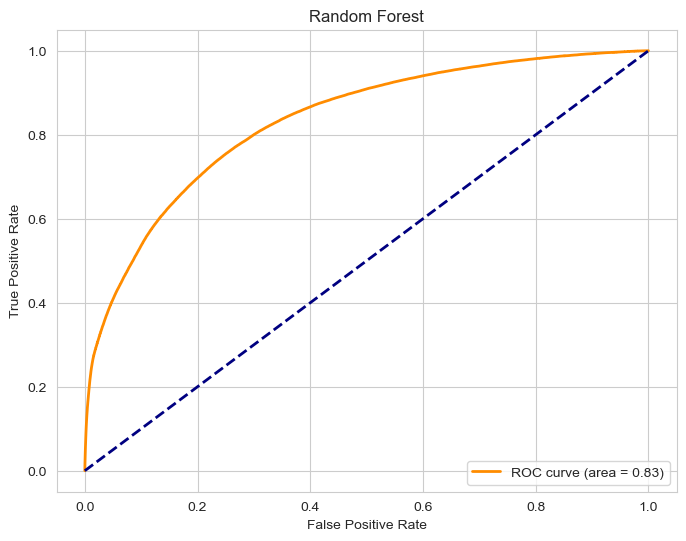

In [32]:
plot_roc_curve(y_test, y_test_proba_rf, model_name=title_rf)

[[7039526  653644]
 [ 294756 2243990]]
[[3004968  292105]
 [  52401   53310]]


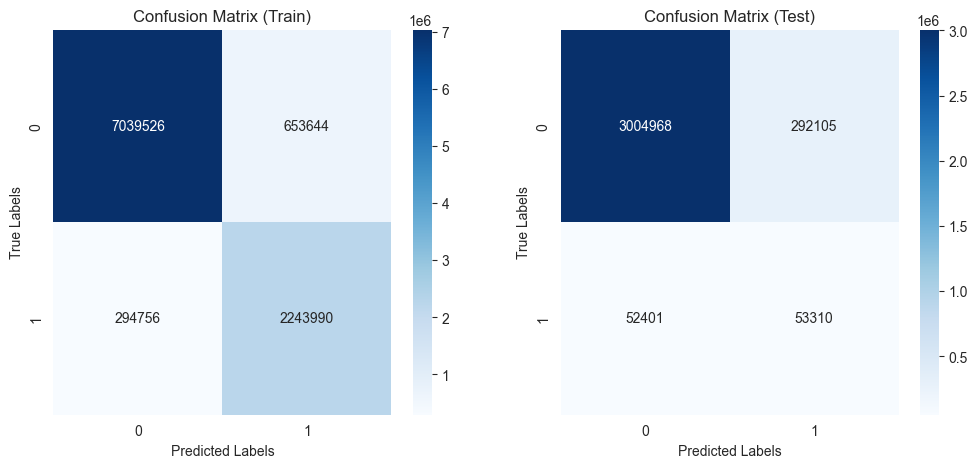

              Train      Test
Metric                       
Recall     0.899466  0.707852
AUC        0.966198  0.830735
Accuracy   0.907310  0.898758
Precision  0.867116  0.568598
F1 Score   0.881217  0.591063


In [62]:
resultat_rf = evaluate_tree_ensemble_model(rf_model, X_train, y_train, X_test, y_test,
                             y_train_proba_rf, y_test_proba_rf)

In [ ]:
len(y_test_proba_rf)

In [ ]:
len(y_test_pred_rf)

In [73]:
title  ='Random Forest'

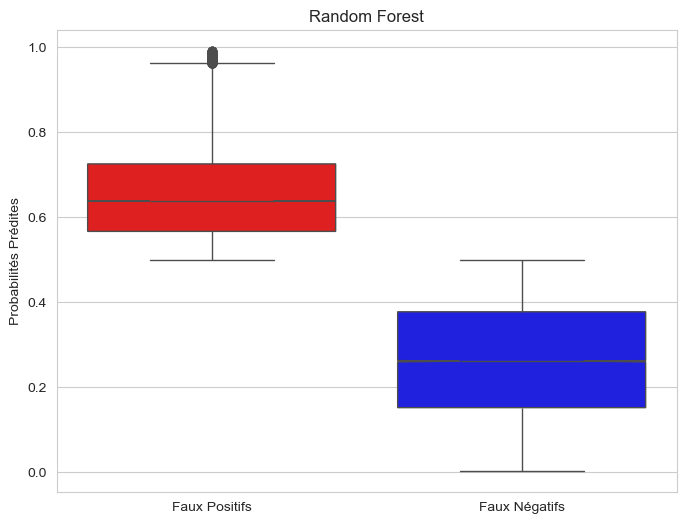

In [76]:
plot_boxplot_of_probabilities(rf_model, X_test, y_test, y_test_proba_rf, title)

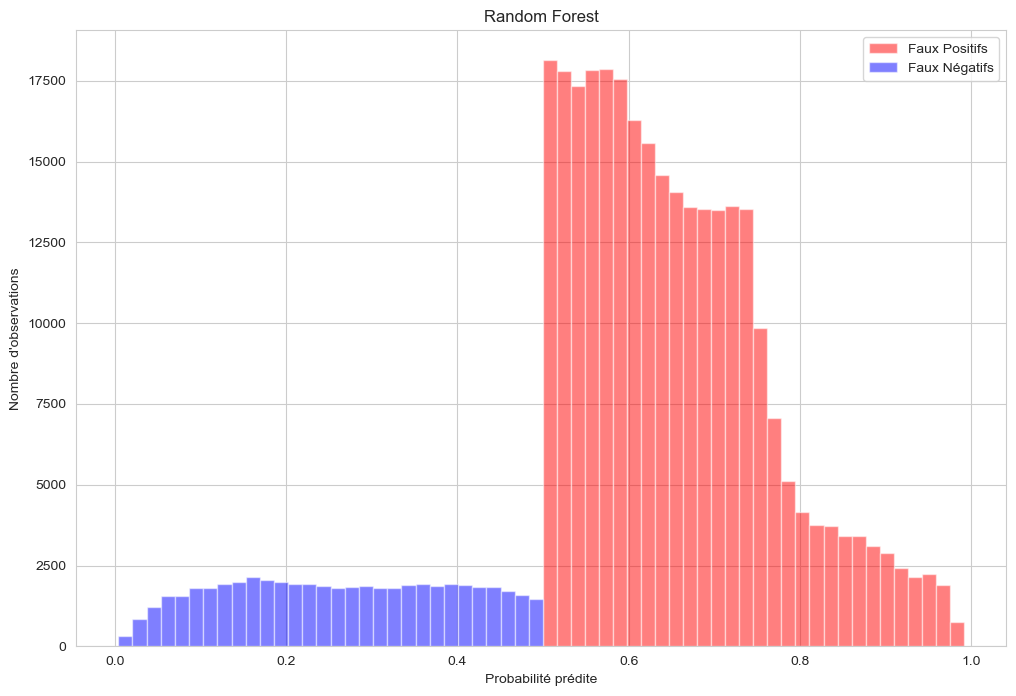

In [77]:
plot_confidence_histogram(rf_model, X_test, y_test, y_test_proba_rf, title)

In [93]:
feature_names = data.columns.tolist()
feature_names.remove("NoShow")
feature_names.remove("patientsid")

['sta3n',
 'stopcode',
 'dta',
 'dts',
 'non_va',
 'zip',
 'state',
 'discontinued',
 'typecare',
 'day_of_week',
 'day_of_month',
 'month',
 'hour',
 'service_time',
 'prior_noShow_rate',
 'prior_service_time_avg']

In [34]:
X_test_= pd.read_csv('data/X_test_ns.csv')

In [35]:
feature_names = list(X_test_.columns)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.3min finished


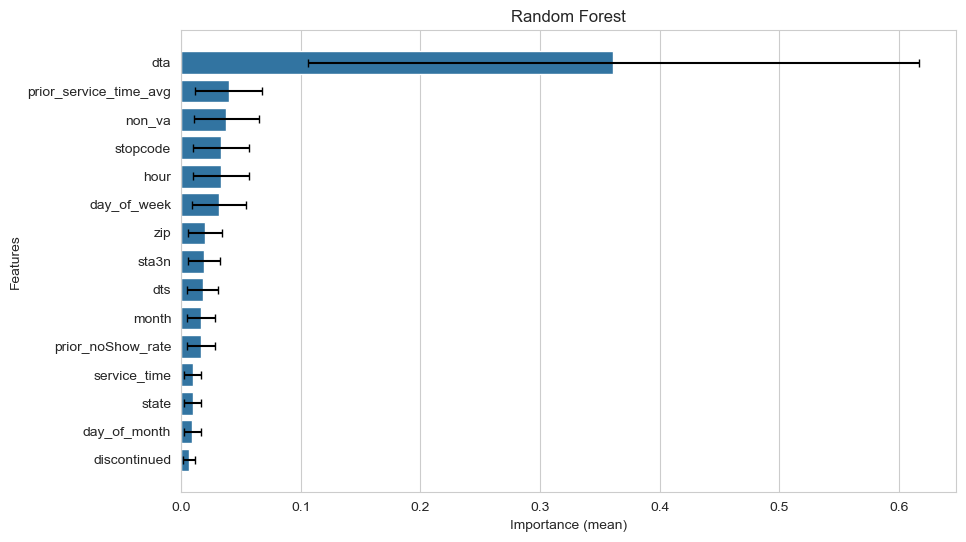

In [68]:
from sklearn.utils import resample
plot_feature_importances_bootstrap(rf_model, X_train, y_train, feature_names, title_rf, n_iterations = 2)

<a name="4.2"></a>
## 4.2 - XGBoosting

<a name="4.2.1"></a>
### 4.2.1 - Training model

In [41]:
# Chargement du modèle
xgb_model = load('best_xgb_classification.joblib')
print("Paramètres du modèle de XGB:")
print(xgb_model.get_params())

Paramètres du modèle de XGB:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.3, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 20, 'max_leaves': None, 'min_child_weight': 2, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 0, 'reg_alpha': 0.2, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 3.0303031496652286, 'subsample': 0.4, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [104]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

# Définition de la grille d'hyperparamètres
param_grid = {
    'n_estimators': [1000],
    'max_depth': [20, 25],
    'min_child_weight': [2],
    'gamma': [0.3],
    'subsample': [0.4],
    'reg_alpha': [0.2],
    'learning_rate': [0.01,0.1]
}

In [109]:
y_train.value_counts()

0    7693170
1    2538746
Name: NoShow, dtype: int64

In [108]:
total_classes = y_train.value_counts()
nombre_total_de_classes_positives = total_classes[1]  # Classe positive (supposons que c'est la classe 1)
nombre_total_de_classes_negatives = total_classes[0]  # Classe négative (supposons que c'est la classe 0)
scale_pos_weight = (nombre_total_de_classes_negatives) / (nombre_total_de_classes_positives)

In [ ]:
# Configuration de GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        objective='binary:logistic',
        n_jobs=-1,
        random_state=0
    ),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Exécution de la recherche en grille
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("Meilleurs hyperparamètres trouvés : ", grid_search.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [ ]:
# Récupération du meilleur modèle
xgb_model = grid_search.best_estimator_

In [42]:
y_test_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]  
y_train_proba_xgb = xgb_model.predict_proba(X_train)[:, 1]

In [ ]:
#dump(best_xgb_model, 'best_xgb_classification.joblib')
print("Modèle enregistré avec succès.")

Modèle enregistré avec succès.


In [43]:
threshold = 0.5
title_xgb  = "XGBoost"

<a name="4.2.2"></a>
### 4.2.2 - Evaluation

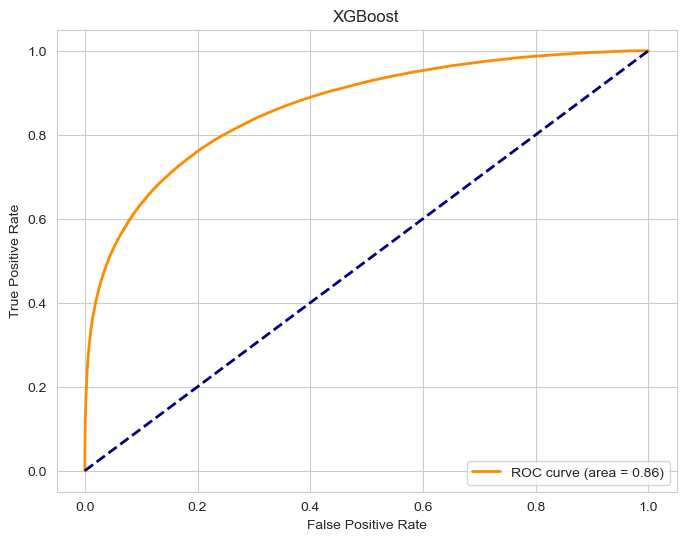

In [44]:
plot_roc_curve(y_test, y_test_proba_xgb, model_name=title_xgb)

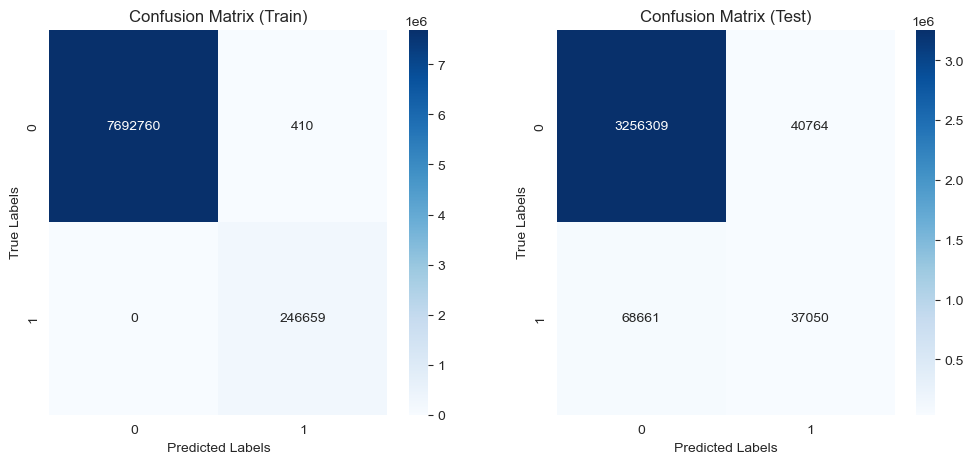

              Train      Test
Metric                       
Recall     0.999973  0.669060
AUC        1.000000  0.864867
Accuracy   0.999948  0.967843
Precision  0.999170  0.727743
F1 Score   0.999571  0.693618


In [66]:
resultat_xgb = evaluate_tree_ensemble_model(xgb_model, X_train, y_train, X_test, y_test, y_train_proba_xgb, y_test_proba_xgb)

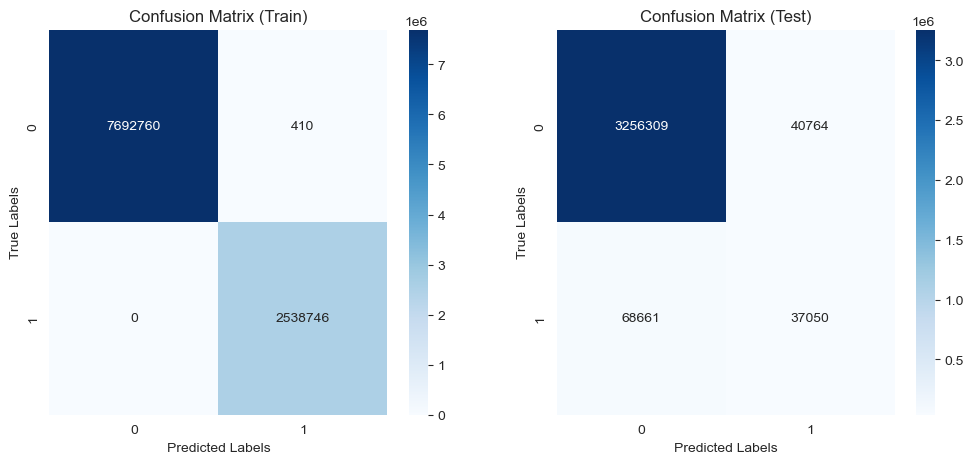

              Train      Test
Metric                       
Recall     0.999973  0.669060
AUC        1.000000  0.864867
Accuracy   0.999960  0.967843
Precision  0.999919  0.727743
F1 Score   0.999946  0.693618


In [37]:
resultat_xgb = evaluate_tree_ensemble_model(xgb_model, X_train, y_train, X_test, y_test, y_train_proba_xgb, y_test_proba_xgb)

In [55]:
title  = "XGBoost"

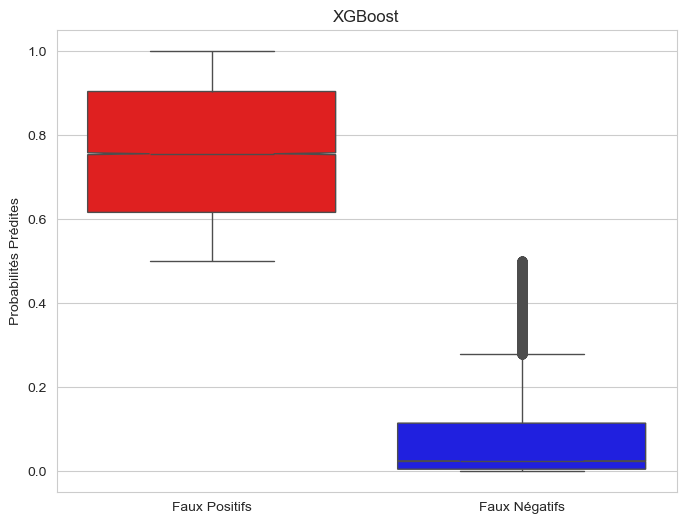

In [67]:
plot_boxplot_of_probabilities(xgb_model, X_test, y_test, y_test_proba_xgb, title)

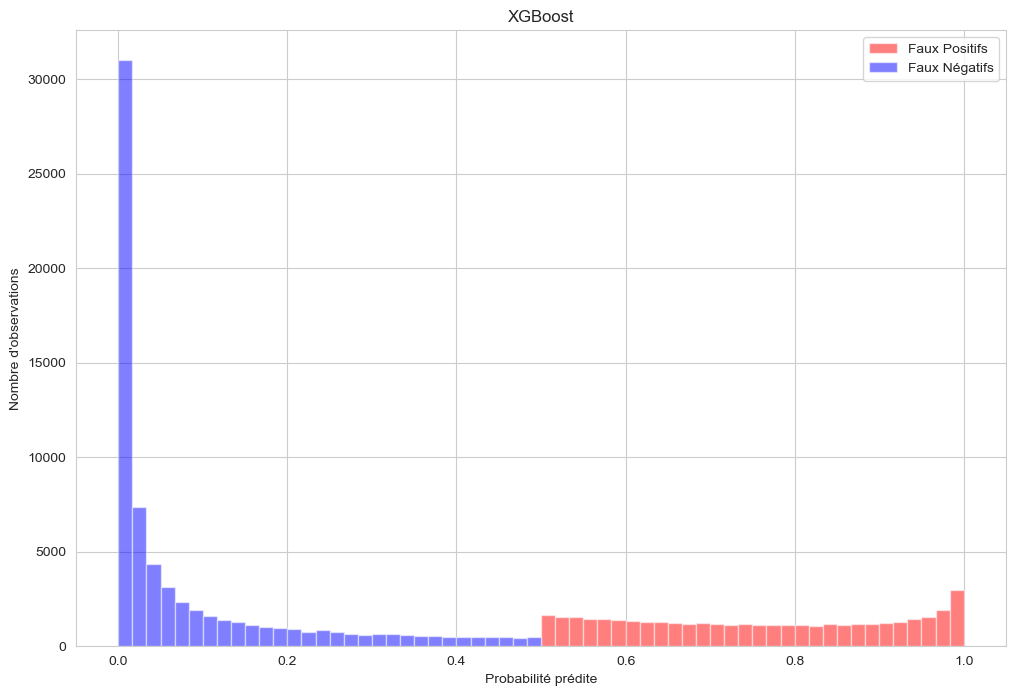

In [68]:
plot_confidence_histogram(xgb_model, X_test, y_test, y_test_proba_xgb, title)

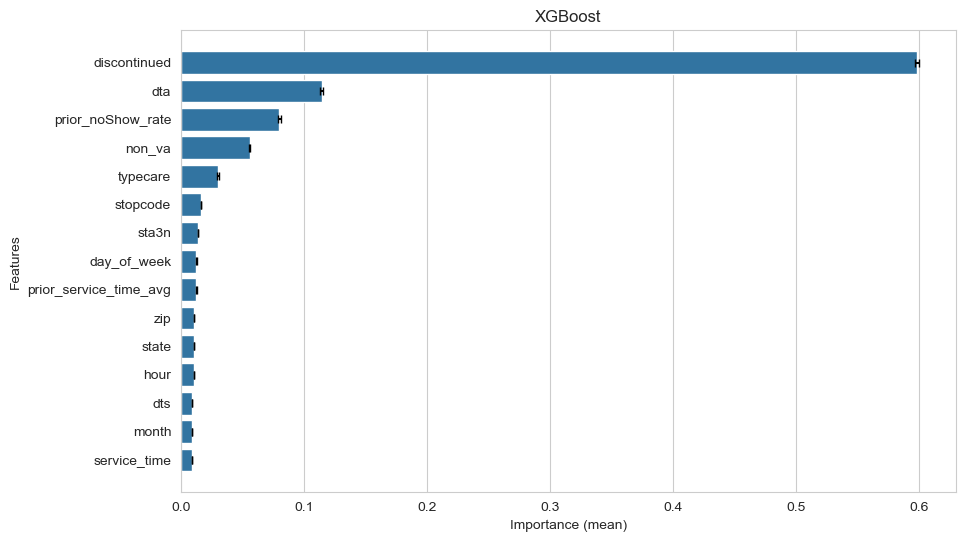

In [66]:
plot_feature_importances_bootstrap(xgb_model, X_train, y_train, feature_names, title_xgb, n_iterations = 2)

<a name="4.3"></a>
## 4.4 - Ada Boost

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

<a name="4.4.1"></a>
### 4.4.1 - Training model

In [150]:
# Chargement du modèle
best_ada_model = load('best_ada_classification.joblib')
print("Paramètres du modèle de AdaBoosting:")
print(best_ada_model.get_params())

Paramètres du modèle de AdaBoosting:
{'algorithm': 'SAMME.R', 'estimator': None, 'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 0}


In [10]:
# Définir le modèle AdaBoost
ada_model = AdaBoostClassifier(random_state=0)
# Définir les hyperparamètres à explorer
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.05, 0.1]
}

In [11]:
# Configurer la recherche en grille
grid_search = GridSearchCV(estimator=ada_model, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)

# Ajuster le modèle avec GridSearchCV
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres trouvés
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Meilleur modèle ajusté
best_ada_model = grid_search.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best hyperparameters: {'learning_rate': 0.1, 'n_estimators': 100}


In [12]:
best_ada_model = grid_search.best_estimator_

In [13]:
from joblib import dump, load
dump(best_ada_model, 'best_ada_classification.joblib')
print("Modèle enregistré avec succès.")

Modèle enregistré avec succès.


In [15]:
dump(grid_search, 'grid_search_ada_classification.joblib')
print("Modèle enregistré avec succès.")

Modèle enregistré avec succès.


In [159]:
y_test_proba_ada = best_ada_model.predict_proba(X_test)[:, 1]
y_train_proba_ada = best_ada_model.predict_proba(X_train)[:, 1]

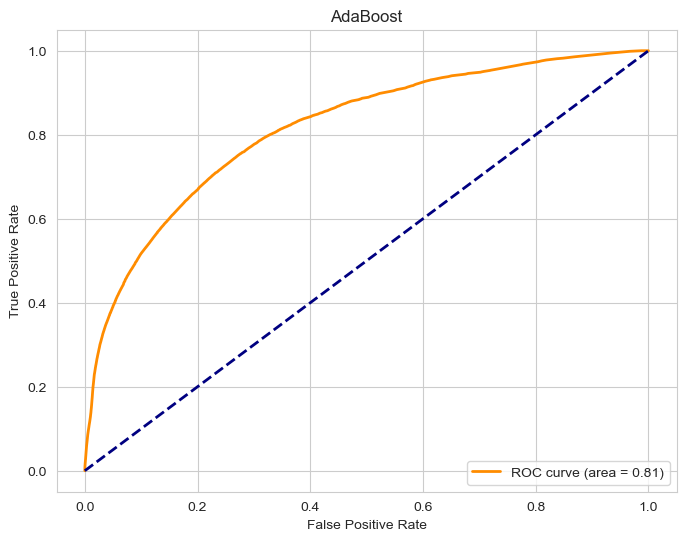

In [17]:
# Calcul des taux pour la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_ada)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [163]:
threshold = 0.5
y_train_pred_ada = (y_train_proba_ada >= threshold).astype(int)
y_test_pred_ada = (y_test_proba_ada >= threshold).astype(int)

<a name="4.4.2"></a>
### 4.4.2 - Evaluation

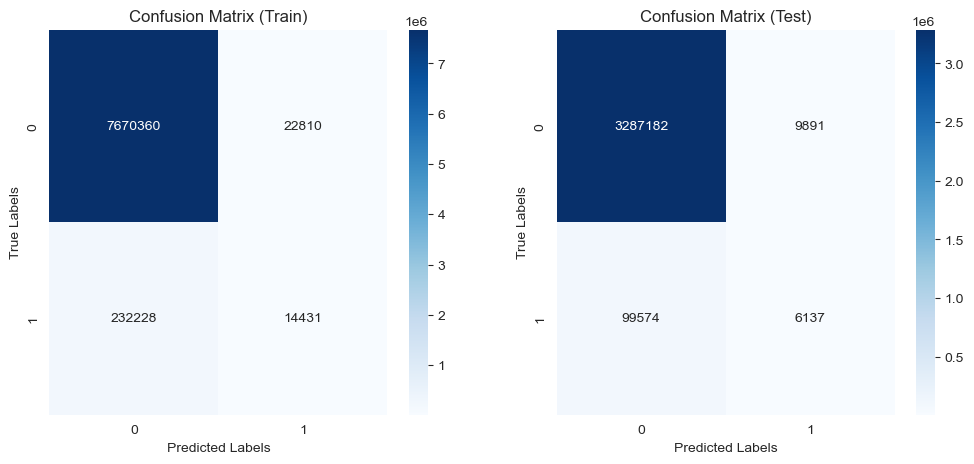

              Train      Test
Metric                       
Recall     0.527770  0.527527
AUC        0.813607  0.814743
Accuracy   0.967879  0.967831
Precision  0.679058  0.676746
F1 Score   0.542655  0.542222


In [87]:
resultat_ada = evaluate_tree_ensemble_model(best_ada_model, X_train, y_train, X_test, y_test, y_train_proba_ada, y_test_proba_ada, threshold=0.49)

In [ ]:
title_ada  = 'AdaBoost'

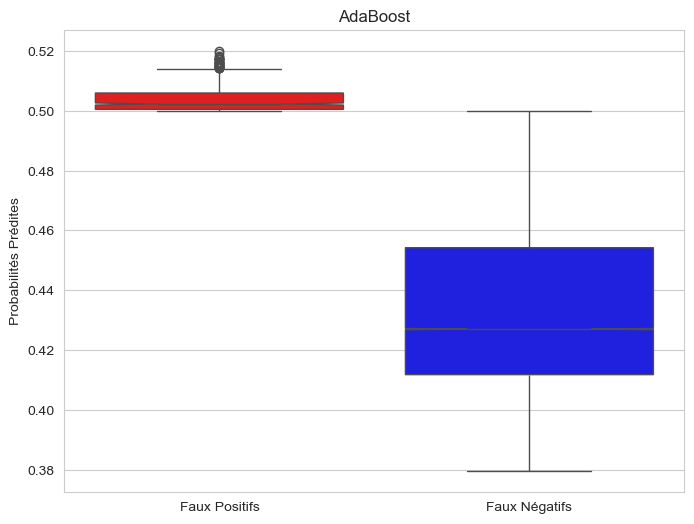

In [45]:
plot_boxplot_of_probabilities(best_ada_model, X_test, y_test, y_test_proba_ada, title, threshold = 0.5)

In [ ]:
plot_confidence_histogram(best_ada_model, X_test, y_test, y_test_proba_ada, title, threshold = 0.5)

In [30]:
feature_names = pd.read_csv("data/X_test_ns.csv").columns.tolist()

In [31]:
feature_names

['sta3n',
 'stopcode',
 'dta',
 'dts',
 'non_va',
 'zip',
 'state',
 'discontinued',
 'typecare',
 'day_of_week',
 'day_of_month',
 'month',
 'hour',
 'service_time',
 'prior_noShow_rate',
 'prior_service_time_avg']

In [74]:
title_ada  = "Adaboost"

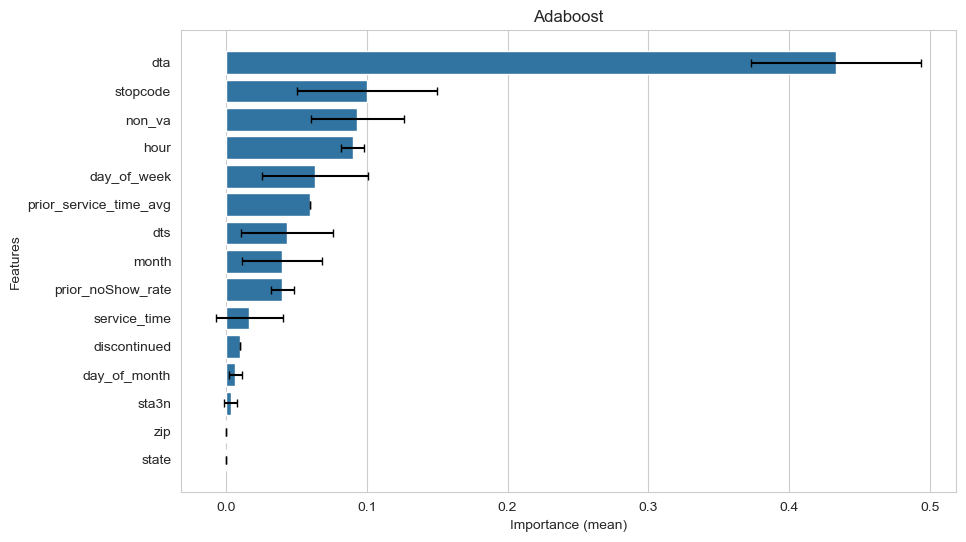

In [76]:
from sklearn.utils import resample
plot_feature_importances_bootstrap(best_ada_model, X_train, y_train, feature_names, title_ada, n_iterations = 2)

<a name="4.4"></a>
## 4.4 - ANN (MLP)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold


In [3]:
# Chargement du modèle
model = load_model('model_mlp_ns_best.keras')
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,349 (5.27 KB)

 Trainable params: 449 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 900 (3.52 KB)

None


In [31]:
# Définir le modèle MLP
def build_mlp_model(input_shape):
    model = Sequential([
        Dense(16, input_shape=(input_shape,), activation='relu'),
        Dropout(0.1),
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    return model

input_shape = X_train.shape[1]

model = build_mlp_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min')

# Entraînement du modèle avec des poids de classe
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50, batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
319748/319748 ━━━━━━━━━━━━━━━━━━━━ 607s 2ms/step - AUC: 0.8211 - accuracy: 0.8107 - loss: 0.4210 - precision: 0.7061 - recall: 0.4047 - val_AUC: 0.7867 - val_accuracy: 0.9474 - val_loss: 0.2197 - val_precision: 0.2335 - val_recall: 0.3041 - learning_rate: 0.0010
Epoch 2/50
319748/319748 ━━━━━━━━━━━━━━━━━━━━ 619s 2ms/step - AUC: 0.8373 - accuracy: 0.8188 - loss: 0.4056 - precision: 0.7175 - recall: 0.4437 - val_AUC: 0.7823 - val_accuracy: 0.9327 - val_loss: 0.2387 - val_precision: 0.1872 - val_recall: 0.3490 - learning_rate: 0.0010
Epoch 3/50
319748/319748 ━━━━━━━━━━━━━━━━━━━━ 617s 2ms/step - AUC: 0.8410 - accuracy: 0.8191 - loss: 0.4027 - precision: 0.7134 - recall: 0.4528 - val_AUC: 0.7923 - val_accuracy: 0.9371 - val_loss: 0.2418 - val_precision: 0.2035 - val_recall: 0.3514 - learning_rate: 0.0010
Epoch 4/50
319748/319748 ━━━━━━━━━━━━━━━━━━━━ 618s 2ms/step - AUC: 0.8371 - accuracy: 0.8186 - loss: 0.4057 - precision: 0.7147 - recall: 0.4463 - val_AUC: 0.7974 - val_accuracy:

In [32]:
#  save model
model.save('model_mlp_ns_best.keras')
print("Modèle enregistré avec succès.")

Modèle enregistré avec succès.


In [21]:
# Get probabilities for the positive class
y_test_proba_ann = model.predict(X_test)[:, 0]
y_train_proba_ann = model.predict(X_train)[:, 0]

106337/106337 ━━━━━━━━━━━━━━━━━━━━ 358s 3ms/step
319748/319748 ━━━━━━━━━━━━━━━━━━━━ 1072s 3ms/step


In [22]:
threshold=0.5
# Apply threshold to convert probabilities to binary classification
y_test_pred_ann = (y_test_proba_ann >= threshold).astype(int)
y_train_pred_ann = (y_train_proba_ann >= threshold).astype(int)

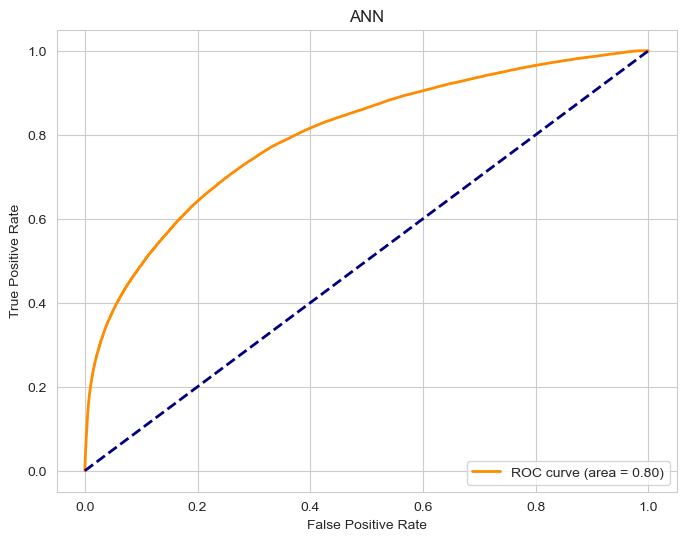

In [23]:
# Calcul des taux pour la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_ann)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

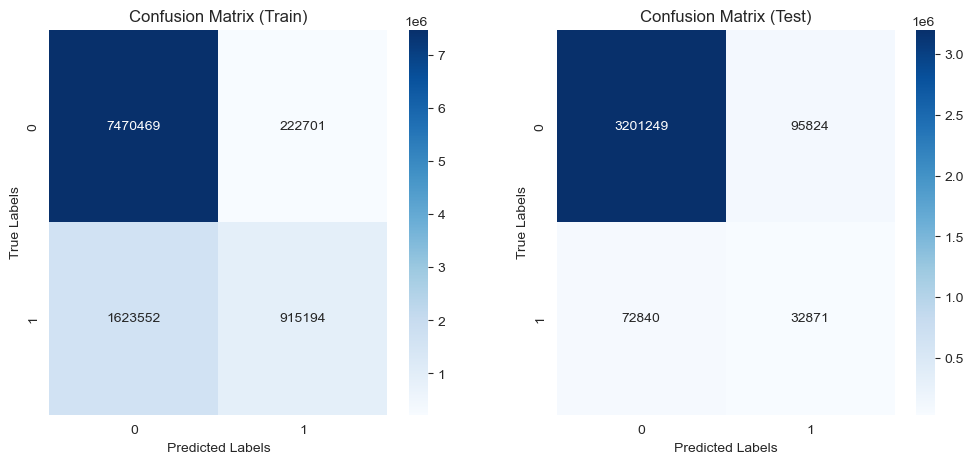

              Train      Test
Metric                       
Recall     0.665771  0.640944
AUC        0.848112  0.797446
Accuracy   0.819559  0.950434
Precision  0.812879  0.616585
F1 Score   0.693931  0.627397


In [39]:
ann_results = evaluate_model(model, X_train, y_train, X_test, y_test,
               y_test_proba_ann, y_train_proba_ann, y_test_pred_ann, y_train_pred_ann)

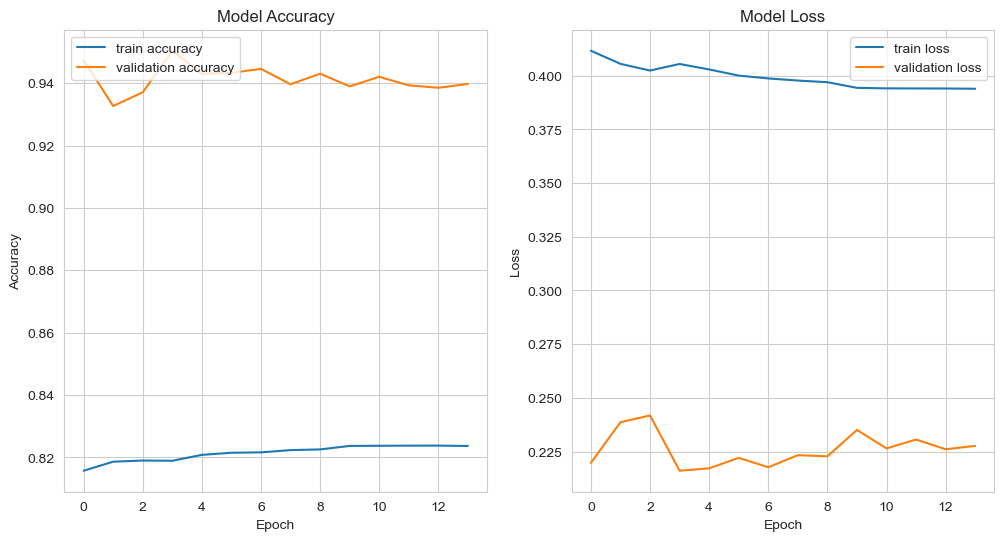

In [36]:
# Utilisation de la fonction
plot_learning_curve_ann(history)

In [41]:
feature_names = data.columns.tolist()
feature_names.remove("NoShow")

In [42]:
feature_names

['sta3n',
 'stopcode',
 'dta',
 'dts',
 'non_va',
 'zip',
 'state',
 'discontinued',
 'typecare',
 'day_of_week',
 'day_of_month',
 'month',
 'hour',
 'service_time',
 'prior_noShow_rate',
 'prior_service_time_avg']

In [89]:
from sklearn.metrics import r2_score
metric=r2_score

#test_score = model.evaluate(X, y, verbose=0)

In [92]:
importances_scores = permutation_importance_bootstrap(model, X_train, y_train, test_score=None, num_rounds=1, n_iterations=2)

In [141]:
importances_scores

,feature,importance_mean,importance_std
0,sta3n,0.005663,0.059374
1,stopcode,0.082117,0.099121
2,dta,0.644058,0.055726
3,dts,0.009595,0.053938
4,non_va,0.079866,0.079111
5,zip,0.004589,0.057933
6,state,0.006400,0.075736
7,discontinued,0.010836,0.067582
8,typecare,0.042987,0.057878
9,day_of_week,0.034997,0.055014


In [146]:
importances_scores['importance_std'] = importances_scores['importance_std'] * importances_scores['importance_std'].max()

In [144]:
importances_scores['feature'] = feature_names
# Normaliser les scores pour que leur somme soit égale à 1
total_importance = importances_scores['importance_mean'].sum()
importances_scores['importance_mean'] = importances_scores['importance_mean'] / total_importance

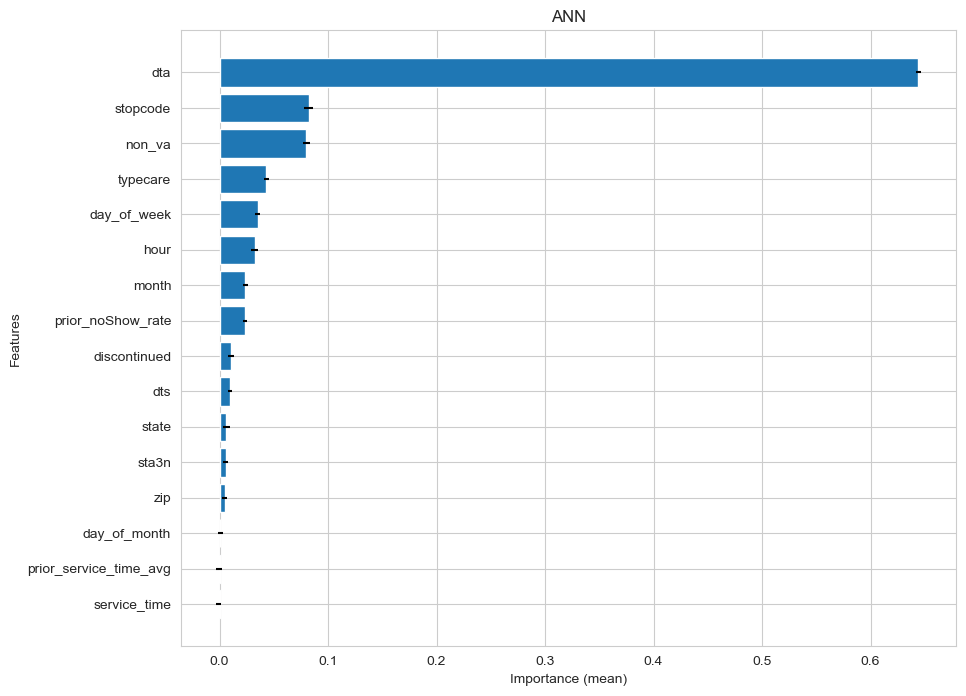

In [149]:
# Utilisation de la fonction pour tracer les importances des caractéristiques du modèle ANN
plot_permutation_importance(importances_scores, 'ANN')

In [51]:
importances_scores = permutation_importance(model, X, y, metric=r2_score, test_score=test_score, num_rounds=1)

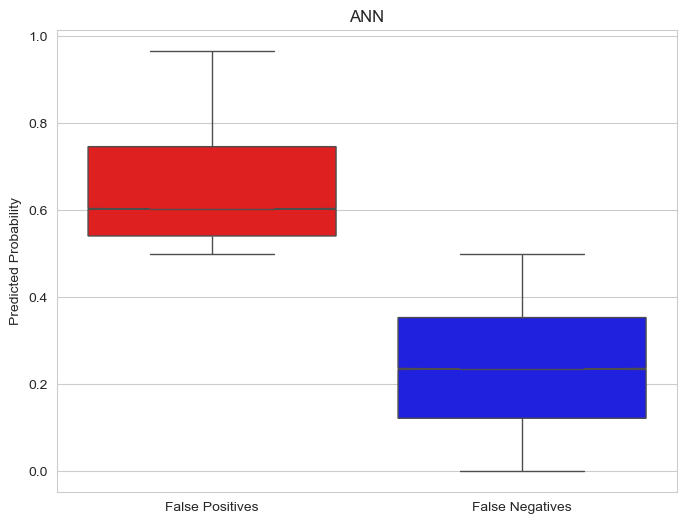

In [32]:

plot_boxplot_of_probabilities(model, X_test, y_test, y_test_proba_ann)

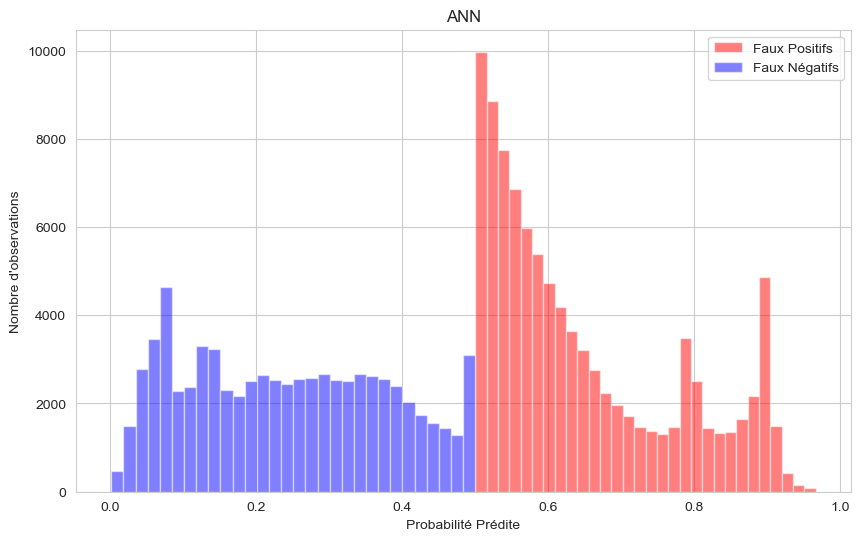

In [62]:
plot_confidence_histogram(model, X_test, y_test, y_test_proba_ann)

In [ ]:
# Sauvegarde des résultats dans un fichier CSV
save_results_to_csv('model_results.csv', dataframes)
<a name="4.4.1"></a>
### 4.4.1 - Training m

#### Explication des métriques utilisées

We assess our model using key metrics and visualizations to understand its performance across various aspects:

### Metrics
- **Precision**: Measures the accuracy of positive predictions :
  - $$\text{Precision} = \frac{TP}{TP + FP}$$
- **Recall**: Measures the ability to identify all relevant instances (sensitivity):
  - $$\text{Recall} = \frac{TP}{TP + FN}$$
- **Accuracy**: Measures the proportion of true results (both true positives and true negatives):
  - $$\text{Accuracy} = \frac{TP + TN}{TP + FP + TN + FN}$$
- **F1 Score**: Harmonic mean of Precision and Recall, balancing the two metrics :
  - $$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2 \times TP}{2 \times TP + FP + FN}$$


### Visualizations
- **AUC - ROC Curve**: Demonstrates the model's ability to differentiate between classes.
- **Learning Curve**: Shows how the model's performance improves with more training data.